In [28]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("die9origephit/children-vs-adults-images")

# print("Path to dataset files:", path)

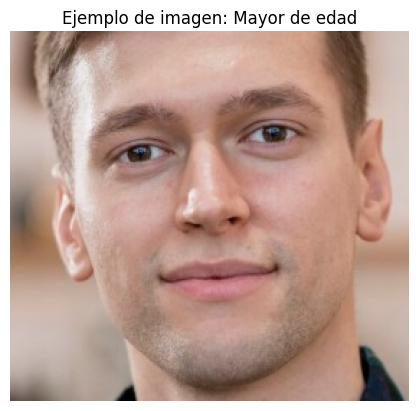

In [29]:
path = "/content/dataset"  # o donde subiste tus carpetas

# Cargar imágenes desde la clase "Mayores_18"
train_adults_path = os.path.join(path, 'Mayores_18')
image_files = os.listdir(train_adults_path)

# Cargar y mostrar la primera imagen de la clase
img_path = os.path.join(train_adults_path, image_files[0])
img = Image.open(img_path)

# Mostrar imagen en Google Colab
plt.imshow(img)
plt.axis('off')
plt.title("Ejemplo de imagen: Mayor de edad")
plt.show()

Procesar las imágenes

In [30]:
# import os
# from PIL import Image
# import matplotlib.pyplot as plt

# # Ruta de imágenes de entrenamiento (adultos)
# train_adults_path = os.path.join(path, 'train', 'adults')
# image_files = os.listdir(train_adults_path)

# # Cargar la imagen
# img_path = os.path.join(train_adults_path, image_files[0])
# img = Image.open(img_path)

# # Mostrar imagen en Google Colab
# plt.imshow(img)
# plt.axis('off')  # Oculta los ejes
# plt.title("Ejemplo de imagen: Adulto")
# plt.show()


Generación de los datasets de entrenamiento y validación

In [31]:
import tensorflow as tf
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Asegúrate de que la variable path apunte al directorio raíz del dataset
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

# Crear conjuntos de entrenamiento y validación (usando parte del train como validación)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# # Conjunto de prueba (opcional)
# test_dataset = tf.keras.utils.image_dataset_from_directory(
#     test_dir,
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE
# )


NotFoundError: Could not find directory /content/dataset/train

Normalización

In [ ]:
# ------------------------CHATGPT-----------------------------
# # Dividir el dataset de validación en 2 partes: validación y test
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# print('Número de lotes de validación original:', val_batches.numpy())

# # Asignamos la mitad a test y la otra mitad se queda como validación
# test_dataset = validation_dataset.take(val_batches // 2)
# validation_dataset = validation_dataset.skip(val_batches // 2)

# print('Número de lotes de validación:', tf.data.experimental.cardinality(validation_dataset).numpy())
# print('Número de lotes de test:', tf.data.experimental.cardinality(test_dataset).numpy())


In [ ]:
# --ANA--
# Cargamos, redimensionamos y reordenamos imagenes
# Obtenemos cuantos lotes tiene la partición original de validación
val_batches = tf.data.experimental.cardinality(validation_dataset)
print('Número de lotes de validación original: ', val_batches.numpy())

# Asignamos la mitad a cada partición
test_dataset = validation_dataset.take(val_batches// 2) # Cogemos la mitad
validation_dataset = validation_dataset.skip(val_batches // 2) # Eliminamos la mitad
print('Número de lotes de validación: ', tf.data.experimental.cardinality(validation_dataset).numpy())
print('Número de lotes de test: ', tf.data.experimental.cardinality(test_dataset).numpy())

# Obtenemos numero de lotes que forman la partición de entrenamiento
train_batches = tf.data.experimental.cardinality(train_dataset)
print('Número de lotes de entrenamiento: ', train_batches.numpy())

In [ ]:
# Para evitar bloquear la E/S y mejorar el rendimiento de la carga, hacer lo siguiente:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Carga de datos en lotes: normalización y centrado y estandarización samplewise).
def scaling_normalization(image, label):
 image = tf.cast(image/255., tf.float32)
 return image, label

train_dataset = train_dataset.map(scaling_normalization)
validation_dataset = validation_dataset.map(scaling_normalization)
test_dataset = test_dataset.map(scaling_normalization)


Arquitectura

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# from tensorflow.keras import layers, models

# # Definición del modelo secuencial
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),

#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(1, activation='sigmoid')  # Salida binaria
# ])

In [ ]:
# Compilación del modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()


Compilación del modelo

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Entrenamiento del modelo

In [ ]:
from pathlib import Path
import tensorflow as tf

# Crear directorio para guardar el modelo
path_models = Path('models')
path_experiment = path_models / 'ChildrenVsAdults'
path_experiment.mkdir(exist_ok=True, parents=True)

# Callback para guardar el mejor modelo según val_accuracy
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_experiment / 'children_vs_adults_model.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# # Entrenamiento del modelo
# history_cnn_base = model.fit(
#     train_dataset,
#     epochs=15,
#     validation_data=validation_dataset,
#     callbacks=[model_checkpoint_callback],
#     verbose=1
# )
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Y añádelo al entrenamiento
history_cnn_base = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=[model_checkpoint_callback, early_stop],
    verbose=1
)


In [ ]:
best_model = tf.keras.models.load_model(path_experiment / 'children_vs_adults_model.keras')


Visualización de las curvas de aprendizaje de entrenamiento y validacion

In [ ]:
import matplotlib.pyplot as plt

# Método para la visualización de la exactitud obtenida durante el proceso de entrenamiento tanto en entrenamiento como en validación
def plot_losses(history):
    plt.plot(history.history['loss'], label="Loss - Entrenamiento")
    plt.plot(history.history['val_loss'], label="Loss - Validación")
    plt.ylabel('Pérdidas')
    plt.xlabel('Época')
    plt.legend(loc="upper right")
    plt.title('Pérdidas durante el entrenamiento')

# Método para la visualización de la exactitud obtenida durante el proceso de entrenamiento tanto en entrenamiento como en validación
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label="Entrenamiento")
    plt.plot(history.history['val_accuracy'], label="Validación")
    plt.ylabel('Exactitud')
    plt.xlabel('Época')
    plt.legend(loc="upper right")
    plt.title('Exactitud durante el entrenamiento')

plot_losses(history_cnn_base)

In [ ]:
plot_accuracy(history_cnn_base)

In [ ]:
import matplotlib.pyplot as plt

# Extraer datos del historial
train_acc = history_cnn_base.history['accuracy']
val_acc = history_cnn_base.history['val_accuracy']
train_loss = history_cnn_base.history['loss']
val_loss = history_cnn_base.history['val_loss']

epochs_range = range(1, len(train_acc) + 1)

# Graficar precisión de entrenamiento y validación
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Graficar pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Precisión en test: {test_acc:.2f}")


In [ ]:
def predecir_edad(imagen_path, modelo):
    from PIL import Image
    img = Image.open(imagen_path).convert("RGB").resize((224, 224))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    pred = modelo.predict(img_array)[0][0]
    return int(pred < 0.5)  # 1 si menor, 0 si mayor


In [ ]:
resultado = predecir_edad("cara.jpg", best_model)

if resultado == 1:
    print("🧒 Predicción: MENOR de edad")
else:
    print("🧑 Predicción: MAYOR de edad")


In [ ]:
resultado = predecir_edad("image4.jpg", best_model)
if resultado == 1:
    print("🧒 Predicción: MENOR de edad")
else:
    print("🧑 Predicción: MAYOR de edad")